# Implementing a GP prior on Gamma

I'm going to try and implement a Gaussian Process prior on $\Gamma$ as done by Guy in his previous examples.

The relation found by Appourchaux+14 doesn't quite have a functional form but does have structure that could we bell approximated by a GP.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pickle
import os

Lets read in a handful of modes

In [9]:
locs = np.genfromtxt('locs.txt')
mid = int(np.floor(len(locs)/2))
l0s = locs[mid:mid+2,0]
l2s = locs[mid-1:mid+1,2]
modelocs = np.append(l0s, l2s)
modeids = [0]*len(l0s) + [2]*len(l2s)

In [10]:
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')
sel = [(ff >= np.min(modelocs)-25) & (ff <= np.max(modelocs+25))]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

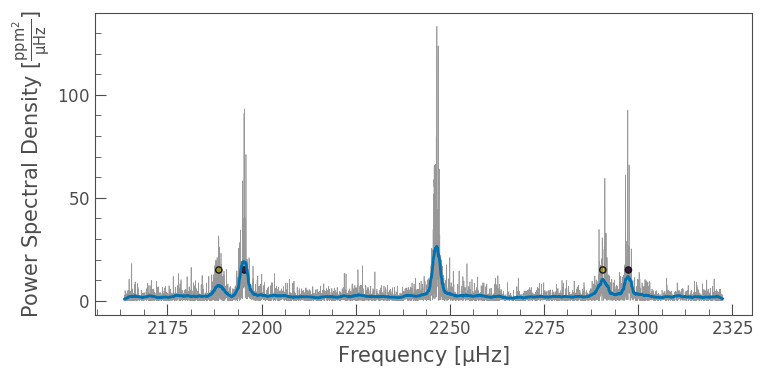

In [11]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

## Treating $\Gamma$

We will describe the mode linewidth as:

$\Gamma_m = 10^{a + b \nu_m}$ ,

where $m$ denotes the mode and $\nu_m$ is the location of the mode.

To approximate this relation we will use a squared exponential kernel, and use a GP based on this kernel as a prior on our values of linewidth:

$K_{i, j} = \alpha^2 \times \exp\left(\frac{-(\nu_i - \nu_j)^2}{2\rho^2}\right)$

where $\nu$ is the frequency and $K$ is the GP kernel, $\alpha$ is the spread and $\rho$ is the length scale. Note that I'm using the same language as the Stan User manual (some other implementations might call these $\sigma$ and $L$ respectively).

In [ ]:
overwrite = False
malatium = '''
functions{      
    vector lorentzian(real loc, int l, int m, vector f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * square(f - loc + m*nus));
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    vector[N] f;      // Frequency
    vector[N] p;      // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
    int asy_ids[M];   // The ID's of the modes
}
parameters{
    real logAmp[M];         // Mode amplitude in log space
    real logGamma[M];       // Mode linewidth in log space
    real locs[M];           // True mode locations
    real vsini;             // Line of sight rotational frequency
    real<lower=0.> nus;     // Rotational frequency splitting
    real<lower=0.1> b;      // Background
}
transformed parameters{
    real H[M];       // Mode height
    real w[M];       // Mode linewidth
    
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform mode linewidth from log space
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    vector[N] modes; // Our Model
    real i;          // Angle of inclination (rad)
    matrix[4,4] eps; // Matrix of legendre polynomials
    int l;           // The radial degree
    
    // First we'll calculate all the legendre polynomials for this i
    i = asin(vsini / nus);
    eps = rep_matrix(1., 4, 4);
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;    

    modes = rep_vector(b, N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = asy_ids[mode];    // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            modes += lorentzian(locs[mode], l, m, f, eps[l+1,abs(m)+1], H[mode], w[mode], nus);
        }
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1.);
    logGamma ~ normal(0, .05);
    locs ~ normal(asy_locs, 1);
    nus ~ normal(0.411, 0.1);
    vsini ~ uniform(0.,nus);
    
    b ~ normal(1.,.1);
}
'''
model_path = 'malatium.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = malatium, model_name='malatium')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = malatium, model_name='malatium')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()